Trabajo fin de máster:  
#### SISTEMA DE PREDIAGNÓSTICO DE NEUMONÍA MEDIANTE INTELIGENCIA ARTIFICIAL
Autor: **José María de Cuenca**

Cuaderno: **8 - Modelo de predicción de pneumonia mediante ensemble**


In [1]:
### ##########################################################
### DIAGNOSTICO DE PNEUMONIA CON RADIOGRAFIAS
### Jose Maria de Cuenca
### ##########################################################

%matplotlib inline

## Importo librerias y cargo funciones
# Generales, acceso y exploración de archivos
import os
import numpy as np
import pandas as pd
from PIL import Image

# Graficos
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

# Carga de conjuntos de datos
import time
import cv2
from skimage.io import imread
from skimage.transform import resize

# Informes y matrices de confusion
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

# Analisis de componentes principales
from sklearn.decomposition import PCA

# Modelos SVM
from sklearn.svm import SVC

# Guardar modelos SVM
from sklearn.externals import joblib

# Tuneado de modelos
from sklearn.model_selection import GridSearchCV

# Conversion de datos a categorias
from keras.utils.np_utils import to_categorical

# Keras para modelos RN
from keras.models import Sequential
from keras.layers import Dense , Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop, Adam
from keras.layers import Conv2D , BatchNormalization
from keras.layers import Input, SeparableConv2D
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

# Tunning para RNs
from keras.wrappers.scikit_learn import KerasClassifier

# Llamada interna para monitorizacion de procesos de entrenamiento
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint

# Monitorizacion de entrenamiento de RNs
from keras.callbacks import TensorBoard


Using TensorFlow backend.


**Análisis exploratorio:**  

En este cuaderno final sigo la estructura de las pruebas. Comienzo elaborando el dataframe a partir de las imágenes del dataset, con datos sobre ellas, no con las imágenes en sí.

Con ese dataframe extraigo un resumen estadístico de las características de las imágenes del dataset, y muestro ejemplos de algunas de ellas, tanto para 2 como para 3 clases.

In [2]:
### ACCESO Y EXPLORACION DE ARCHIVOS DE DATOS

# Uso el sistema para obtener la Lista con todos los ficheros de la ruta
path = './data/chest_xray' # Variable para la ruta al directorio
lstDir = os.walk(path)   #os.walk()Lista directorios y ficheros


# Creo lista para extraer los datos de la anterior del sistema
# Lista vacia para rellenar con datos de los ficheros
lstFiles = []

for root, dirs, files in lstDir:
    for fichero in files:
        # Separo nombre del fichero de la extension
        (nombreFichero, extension) = os.path.splitext(fichero)
        
        # Controlo que solo se procesen los ficheros jpeg (evitando los .DS_Store u otros)
        if extension == ".jpeg":
            # Compongo la ruta completa, convirtiendo a tipo Unix para independizar de SO. Ojo escape 
            ruta = root.replace("\\", "/")+"/"+nombreFichero+extension
            # Uso la ruta completa como identificador de la imagen
            lstFiles.append(ruta)
            
            # Extraigo el subconjunto de partida
            if root.find("train")>0:
                lstFiles.append("TRAIN")
            else:
                if root.find("test")>0:
                    lstFiles.append("TEST")
                else:
                    lstFiles.append("VAL")
        
            # Extraigo el diagnostico
            if root.find("NORMAL")>0:
                lstFiles.append("NORMAL")
                lstFiles.append("0")
            else:
                lstFiles.append("PNEUMONIA")
                lstFiles.append("1")
        
            # Extraigo el tipo de infeccion
            if root.find("PNEUMONIA")>0:
                if nombreFichero.find("bacteria")>0:
                    lstFiles.append("BACTERIA")
                    lstFiles.append("1")
                else:
                    lstFiles.append("VIRUS")
                    lstFiles.append("2")
            else:
                lstFiles.append("NONE")
                lstFiles.append("0")
                
            # Cargo la imagen para sacar caracteristicas internas
            imagen = Image.open(ruta)
            lstFiles.append(imagen.mode)
            lstFiles.append(imagen.size[0]) # anchura
            lstFiles.append(imagen.size[1]) # altura
            lstFiles.append(round(imagen.size[0]*imagen.size[1]/1000000, 2)) # resolucion Megapixeles
            lstFiles.append(round(imagen.size[0]/imagen.size[1], 4)) # relacion de aspecto



# Para poder crear tabla necestio hacer reshape en la lista. Es necesario pasar por array numpy.          
# Convierto la lista en array numpy
npdf_files = np.array(lstFiles)
# Lo llevo al formato de columnas ordenadas
npdf_files = npdf_files.reshape([-1,11])

# Compruebo que es correcto
print(npdf_files.shape)

# Creo un dataframe de pandas
df_file = pd.DataFrame(npdf_files, columns=['fichero', 'conjunto', 'diagnostico','diag_ct','patogeno', 'patog_ct','color','x_res', 'y_res', 'res_Mpx', 'rel_asp'])

# Lo grabo como csv
df_file.to_csv (path+'/df_file.csv', index = None, header=True)

# Compruebo
df_file.head(10)

(5856, 11)


fichero conjunto diagnostico  \
0    ./data/chest_xray/test/NORMAL/IM-0001-0001.jpeg     TEST      NORMAL   
1    ./data/chest_xray/test/NORMAL/IM-0003-0001.jpeg     TEST      NORMAL   
2    ./data/chest_xray/test/NORMAL/IM-0005-0001.jpeg     TEST      NORMAL   
3    ./data/chest_xray/test/NORMAL/IM-0006-0001.jpeg     TEST      NORMAL   
4    ./data/chest_xray/test/NORMAL/IM-0007-0001.jpeg     TEST      NORMAL   
5    ./data/chest_xray/test/NORMAL/IM-0009-0001.jpeg     TEST      NORMAL   
6    ./data/chest_xray/test/NORMAL/IM-0010-0001.jpeg     TEST      NORMAL   
7  ./data/chest_xray/test/NORMAL/IM-0011-0001-000...     TEST      NORMAL   
8  ./data/chest_xray/test/NORMAL/IM-0011-0001-000...     TEST      NORMAL   
9    ./data/chest_xray/test/NORMAL/IM-0011-0001.jpeg     TEST      NORMAL   

  diag_ct patogeno patog_ct color x_res y_res res_Mpx rel_asp  
0       0     NONE        0     L  1857  1317    2.45    1.41  
1       0     NONE        0     L  2111  1509    3.19  1.3989  
2       0     NONE        0     L  2031  1837    3.73  1.1056  
3       0     NONE        0     L  1663  1326    2.21  1.2541  
4       0     NONE        0     L  2053  1818    3.73  1.1293  
5       0     NONE        0     L  1852  1443    2.67  1.2834  
6       0     NONE        0     L  1873  1478    2.77  1.2673  
7       0     NONE        0     L  2144  1916    4.11   1.119  
8       0     NONE        0     L  2214  1945    4.31  1.1383  
9       0     NONE        0     L  1863  1785    3.33  1.0437

patogeno     BACTERIA  NONE  VIRUS
diagnostico                       
NORMAL              0  1583      0
PNEUMONIA        2780     0   1493


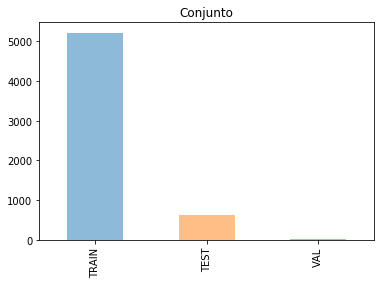

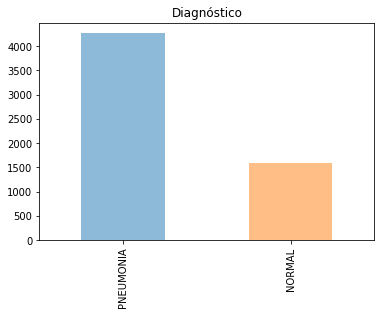

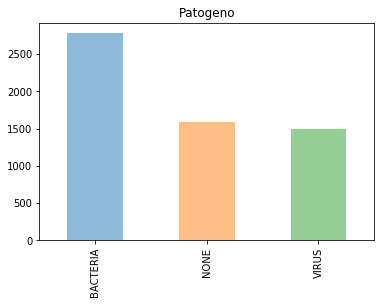

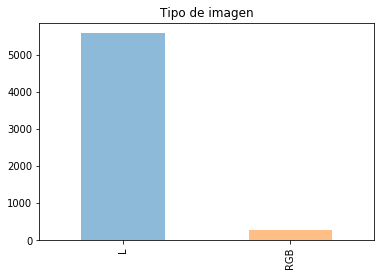

color        L  RGB
patogeno           
BACTERIA  2637  143
NONE      1583    0
VIRUS     1353  140


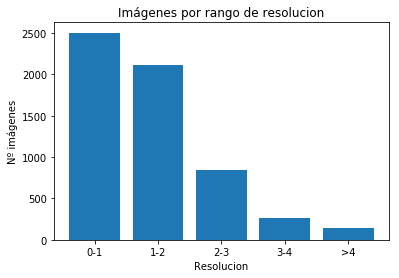

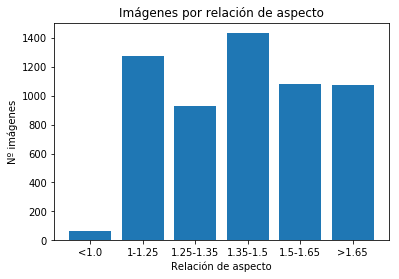

In [3]:
## ANALISIS ESTADISTICO

# Tabla cruzada de casos
tab = pd.crosstab(df_file['diagnostico'], df_file['patogeno'])
print(tab)

# Grafico de registros por conjunto
# Columna de conjunto
df_file['conjunto'].value_counts().plot(kind='bar', alpha=0.5)
plt.title("Conjunto")
plt.show()

# Grafico de registros por categoria
# Columna de diagnostico
df_file['diagnostico'].value_counts().plot(kind='bar', alpha=0.5)
plt.title("Diagnóstico")
plt.show()

# Columna de tipo infección
df_file['patogeno'].value_counts().plot(kind='bar', alpha=0.5)
plt.title("Patogeno")
plt.show()

# Tipo de imagen (codigos de Pil image.mode)
# 1 (1-bit pixels, black and white, stored with one pixel per byte)
# L (8-bit pixels, black and white)
# P (8-bit pixels, mapped to any other mode using a colour palette)
# RGB (3x8-bit pixels, true colour)
# RGBA (4x8-bit pixels, true colour with transparency mask)
# CMYK (4x8-bit pixels, colour separation)
# YCbCr (3x8-bit pixels, colour video format)
# I (32-bit signed integer pixels)
# F (32-bit floating point pixels)

# Columna de tipo imagen
df_file['color'].value_counts().plot(kind='bar', alpha=0.5)
plt.title("Tipo de imagen")
plt.show()

# Indago las imagenes que estan en color por el tipo infeccion
tab = pd.crosstab(df_file['patogeno'], df_file['color'])
print(tab)


## Análisis de imágenes por rango de resolucion

# Defino rangos de resolucion en MegaPixeles
rangos_resol = ['0-1', '1-2', '2-3', '3-4', '>4']

# Cuento el numero de registros en cada rango
reso1 = df_file[(df_file['res_Mpx'].astype(float)< 1.0)]['res_Mpx'].count()
reso2 = df_file[(df_file['res_Mpx'].astype(float)< 2.0)]['res_Mpx'].count() - reso1
reso3 = df_file[(df_file['res_Mpx'].astype(float)< 3.0)]['res_Mpx'].count() - reso2 - reso1
reso4 = df_file[(df_file['res_Mpx'].astype(float)< 4.0)]['res_Mpx'].count() - reso3 - reso2 - reso1
reso5 = df_file[(df_file['res_Mpx'].astype(float)>= 4.0)]['res_Mpx'].count()
# Creo lista de valores por rangos
resol = [reso1, reso2, reso3, reso4, reso5]

# Represento con gráfico de barras
plt.bar(rangos_resol, resol)
plt.xlabel("Resolucion")
plt.ylabel("Nº imágenes")
plt.title("Imágenes por rango de resolucion")
plt.show()


## Análisis de imágenes por relación de aspecto

# Defino rangos de resolucion en MegaPixeles
rangos_aspect = ['<1.0', '1-1.25', '1.25-1.35', '1.35-1.5', '1.5-1.65' , '>1.65']

# Cuento el numero de registros en cada rango
aspe1 = df_file[(df_file['rel_asp'].astype(float)< 1.0)]['rel_asp'].count()
aspe2 = df_file[(df_file['rel_asp'].astype(float)< 1.25)]['rel_asp'].count() - aspe1
aspe3 = df_file[(df_file['rel_asp'].astype(float)< 1.35)]['rel_asp'].count() - aspe2 - aspe1
aspe4 = df_file[(df_file['rel_asp'].astype(float)< 1.5)]['rel_asp'].count() - aspe3 - aspe2 - aspe1
aspe5 = df_file[(df_file['rel_asp'].astype(float)< 1.65)]['rel_asp'].count() - aspe4 - aspe3 - aspe2 - aspe1
aspe6 = df_file[(df_file['rel_asp'].astype(float)>= 1.65)]['rel_asp'].count()
# Creo lista de valores por rangos
aspect = [aspe1, aspe2, aspe3, aspe4, aspe5, aspe6]


# Represento con gráfico de barras
plt.bar(rangos_aspect, aspect)
plt.xlabel("Relación de aspecto")
plt.ylabel("Nº imágenes")
plt.title("Imágenes por relación de aspecto")
plt.show()

Muestra de imágenes con diagnóstico:
['./data/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg', './data/chest_xray/test/PNEUMONIA/person100_bacteria_477.jpeg', './data/chest_xray/test/PNEUMONIA/person100_bacteria_478.jpeg', './data/chest_xray/test/PNEUMONIA/person100_bacteria_479.jpeg', './data/chest_xray/test/NORMAL/IM-0001-0001.jpeg', './data/chest_xray/test/NORMAL/IM-0003-0001.jpeg', './data/chest_xray/test/NORMAL/IM-0005-0001.jpeg', './data/chest_xray/test/NORMAL/IM-0006-0001.jpeg']


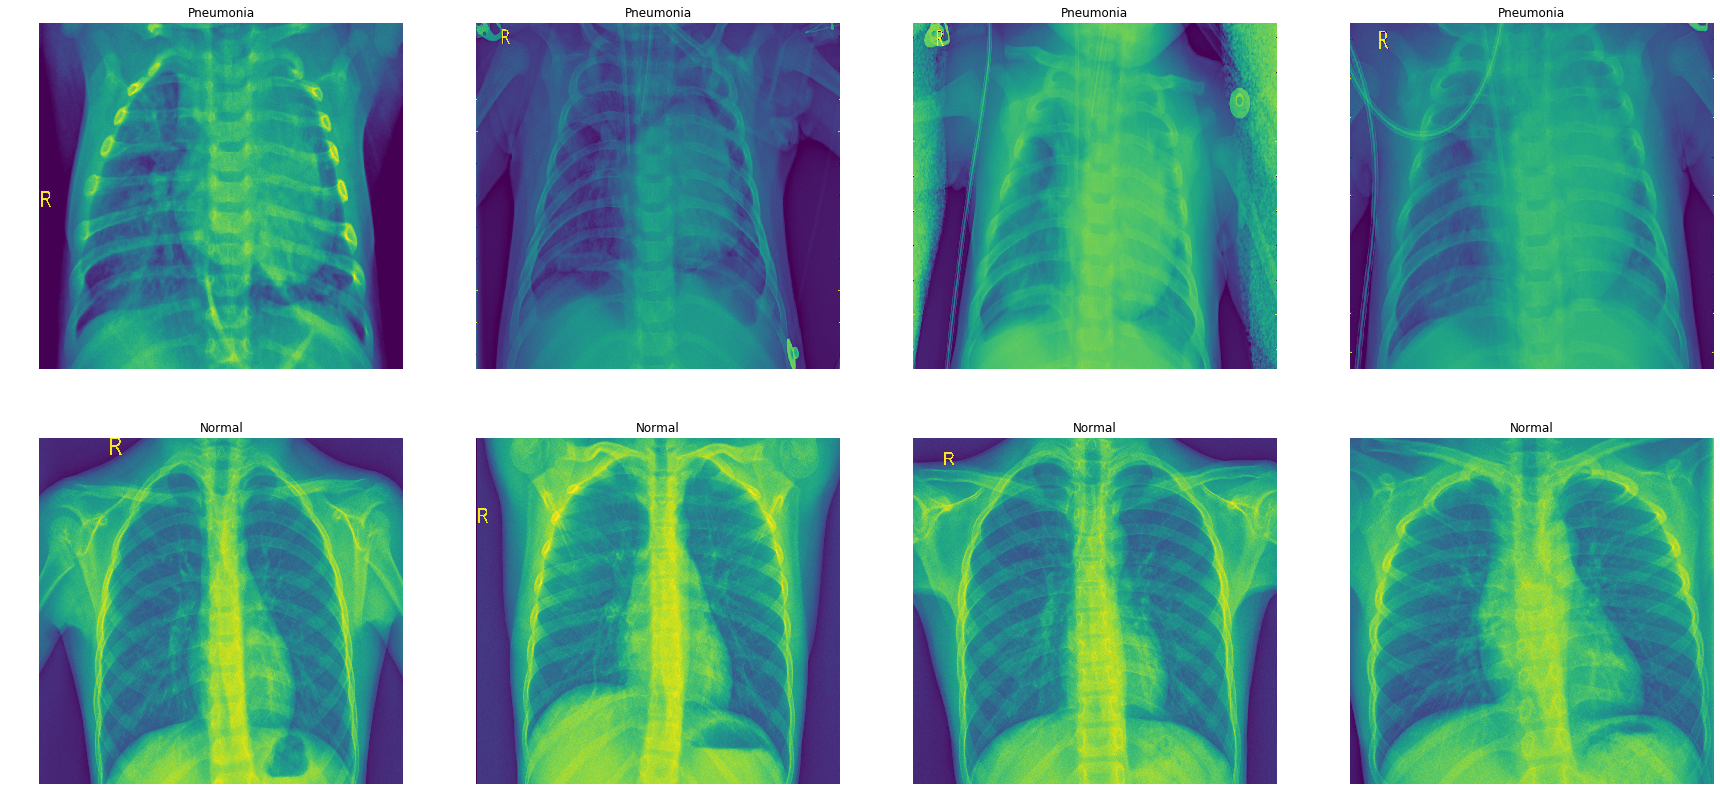

In [4]:
### MUESTRO ALGUNAS IMAGENES DE CADA EN 2 CLASES (DIAGNOSTICO)

print("Muestra de imágenes con diagnóstico:")

# Creo una lista con los 4 primeros registros de cada que hay en la tabla
pneumonia_samples = (df_file[df_file['diagnostico']=='PNEUMONIA']['fichero'].iloc[:4]).tolist()
normal_samples = (df_file[df_file['diagnostico']=='NORMAL']['fichero'].iloc[:4]).tolist()

# Unifico la lista
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

print(samples)

# Represento las imágenes en formato matriz
# Uso la función imread para accedere directamente con la ruta
from skimage.io import imread

# Creo lienzo de dibujo para la matriz de 2x4 = 8 elementos
f, ax = plt.subplots(2,4, figsize=(30,14))

for i in range(8):
    img = imread(samples[i])
    ax[i//4, i%4].imshow(img) #por si hubiese alguna en color
    # Añado rotulos con su procedencia
    if i<4:
        ax[i//4, i%4].set_title("Pneumonia")
    else:
        ax[i//4, i%4].set_title("Normal")
    # Elimino marcas de ejes
    ax[i//4, i%4].axis('off')
    ax[i//4, i%4].set_aspect('auto')
plt.show()


Muestra de imágenes con patógeno:
['./data/chest_xray/test/NORMAL/IM-0001-0001.jpeg', './data/chest_xray/test/NORMAL/IM-0003-0001.jpeg', './data/chest_xray/test/NORMAL/IM-0005-0001.jpeg', './data/chest_xray/test/NORMAL/IM-0006-0001.jpeg', './data/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg', './data/chest_xray/test/PNEUMONIA/person100_bacteria_477.jpeg', './data/chest_xray/test/PNEUMONIA/person100_bacteria_478.jpeg', './data/chest_xray/test/PNEUMONIA/person100_bacteria_479.jpeg', './data/chest_xray/test/PNEUMONIA/person10_virus_35.jpeg', './data/chest_xray/test/PNEUMONIA/person11_virus_38.jpeg', './data/chest_xray/test/PNEUMONIA/person14_virus_44.jpeg', './data/chest_xray/test/PNEUMONIA/person15_virus_46.jpeg']


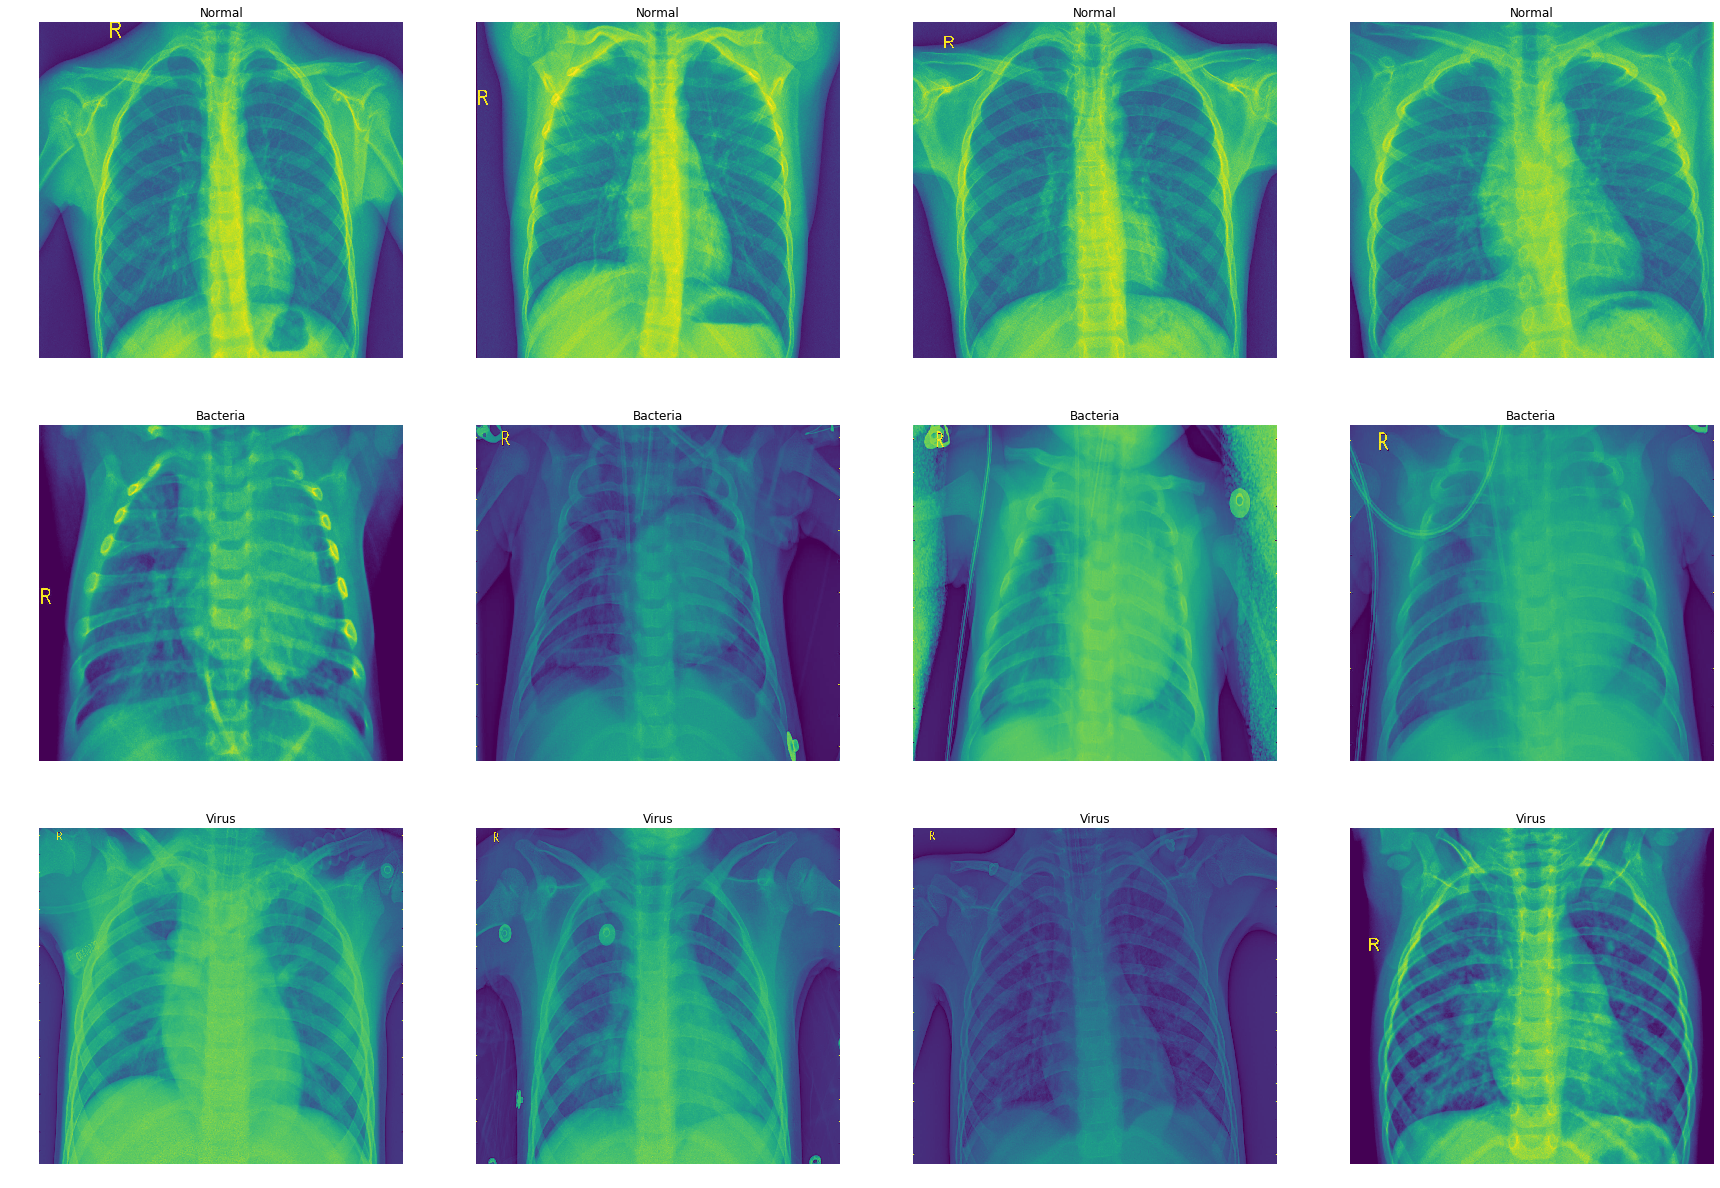

In [5]:
### MUESTRO ALGUNAS IMAGENES DE CADA EN 3 CLASES (PATOGENO)

print("Muestra de imágenes con patógeno:")

# Creo una lista con los 4 primeros registros de cada que hay en la tabla
normal_samples = (df_file[df_file['patogeno']=='NONE']['fichero'].iloc[:4]).tolist()
bacteria_samples = (df_file[df_file['patogeno']=='BACTERIA']['fichero'].iloc[:4]).tolist()
virus_samples = (df_file[df_file['patogeno']=='VIRUS']['fichero'].iloc[:4]).tolist()

# Unifico la lista
samples = normal_samples + bacteria_samples + virus_samples
del normal_samples, bacteria_samples, virus_samples

print(samples)

# Represento las imágenes en formato matriz
# Uso la función imread para accedere directamente con la ruta
from skimage.io import imread

# Creo lienzo de dibujo para la matriz de 2x4 = 8 elementos
f, ax = plt.subplots(3,4, figsize=(30,21))

for i in range(12):
    img = imread(samples[i])
    ax[i//4, i%4].imshow(img) #por si hubiese alguna en color
    # Añado rotulos con su procedencia
    if i<4:
        ax[i//4, i%4].set_title("Normal")
    elif i<8:
        ax[i//4, i%4].set_title("Bacteria")
    else:
        ax[i//4, i%4].set_title("Virus")
    # Elimino marcas de ejes
    ax[i//4, i%4].axis('off')
    ax[i//4, i%4].set_aspect('auto')
plt.show()


**Carga de datos**

Antes de proceder a crear los conjuntos de datos cargando las imágenes de cada carpeta en una matriz de numpy,
redefino el dataframe de la entrada de manera que contenga el mismo número de registros de cada categoría, eliminando el sesgo.

Este resampling es diferente considerando 2 o 3 clases. Por ello se utilizaran conjuntos separados en cada tipo de modelos.  

La carga de ambos grupos de conjuntos se realiza con el método más eficiente de los probados en cuadernos anteriores. Se aprovecha para reescalar las imágenes a un tamaño homogéneo menor (150x150).

In [6]:
## RESAMPLING DE LOS DATOS PARA 2 CLASES
# Reduzco el dataset df_file para eliminar el sesgo en los datos

# En principio solo homogenizo las caracteristica DIAGNOSTICO para que las clases NORMAL y PNEUMONIA tengan igual numero

# Creo subconjuntos de entrenamiento filtrando el dataset original por las clases de la caracteristica
df_TR_NOR = df_file[(df_file['diagnostico'] == 'NORMAL') & (df_file['conjunto']=='TRAIN')]
df_TR_PNE = df_file[(df_file['diagnostico'] == 'PNEUMONIA') & (df_file['conjunto']=='TRAIN')]
# Dejo el resto de subconjuntos del dataset en otro dataframe
df_RESTO = df_file[df_file['conjunto'] !='TRAIN']

# Cuento datos de cada clases
count_NOR = df_TR_NOR.shape[0]
count_PNE = df_TR_PNE.shape[0]
print('Datos por clase de diagnostico en entrenamiento:')
print('count_NOR: ', count_NOR)
print('count_PNE: ', count_PNE)


# Tomo solo el mismo numero de elementos de la clase mas numerosa que de la clase minoritaria
# Fijo una semilla para asegurar reproductibilidad
df_TR_PNE_cut = df_TR_PNE.sample(count_NOR, random_state=7)

# Recompongo el dataset para 2 clases
df_file2 = pd.concat([df_TR_NOR, df_TR_PNE_cut, df_RESTO], axis=0)

# Reviso analisis estadistico

# Tabla cruzada de casos
print('\nDatos por clase y conjunto:')
tab = pd.crosstab(df_file2['diagnostico'], df_file2['conjunto'])
print(tab)


Datos por clase de diagnostico en entrenamiento:
count_NOR:  1341
count_PNE:  3875

Datos por clase y conjunto:
conjunto     TEST  TRAIN  VAL
diagnostico                  
NORMAL        234   1341    8
PNEUMONIA     390   1341    8


In [7]:
## RESAMPLING DE LOS DATOS PARA 3 CLASES
# Reduzco el dataset df_file para eliminar el sesgo en los datos

# En principio solo homogenizo las caracteristica DIAGNOSTICO para que las clases NORMAL y PNEUMONIA tengan igual numero

# Creo subconjuntos de entrenamiento filtrando el dataset original por las clases de la caracteristica
df_TR_SAN = df_file[(df_file['patogeno'] == 'NONE') & (df_file['conjunto']=='TRAIN')]
df_TR_BAC = df_file[(df_file['patogeno'] == 'BACTERIA') & (df_file['conjunto']=='TRAIN')]
df_TR_VIR = df_file[(df_file['patogeno'] == 'VIRUS') & (df_file['conjunto']=='TRAIN')]
# Dejo el resto de subconjuntos del dataset en otro dataframe
df_RESTO = df_file[df_file['conjunto'] !='TRAIN']

# Cuento datos de cada clases
count_SAN = df_TR_SAN.shape[0]
count_BAC = df_TR_BAC.shape[0]
count_VIR = df_TR_VIR.shape[0]
print('Datos por clase de diagnostico en entrenamiento:')
print('count_SAN: ', count_SAN)
print('count_BAC: ', count_BAC)
print('count_VIR: ', count_VIR)


# Tomo solo el mismo numero de elementos de la clase mas numerosa que de la clase minoritaria
# Fijo una semilla para asegurar reproductibilidad
df_TR_BAC_cut = df_TR_BAC.sample(count_NOR, random_state=7)
df_TR_VIR_cut = df_TR_VIR.sample(count_NOR, random_state=7)

# Recompongo el dataset
df_file3 = pd.concat([df_TR_SAN, df_TR_BAC_cut, df_TR_VIR_cut, df_RESTO], axis=0)

# Reviso analisis estadistico

# Tabla cruzada de casos
print('\nDatos por clase y conjunto:')
tab = pd.crosstab(df_file3['patogeno'], df_file3['conjunto'])
print(tab)


Datos por clase de diagnostico en entrenamiento:
count_SAN:  1341
count_BAC:  2530
count_VIR:  1345

Datos por clase y conjunto:
conjunto  TEST  TRAIN  VAL
patogeno                  
BACTERIA   242   1341    8
NONE       234   1341    8
VIRUS      148   1341    0


In [8]:
## CARGA DE DATOS PARA 2 CLASES

# Creo listas con las rutas de las imágenes para cada conjunto
VAL_files2 = (df_file2[df_file2['conjunto']=='VAL']['fichero'].iloc[:]).tolist()
# Creo array con etiquetas para modelo, por ejemplo con columna diagnostico categorizada. Si patogeno, cambiar
VAL_labels2 = (df_file2[df_file2['conjunto']=='VAL']['diag_ct'].iloc[:]).tolist()

# Creo listas para cargar los datos de las imagenes y las etiquetas de cada conjunto
X_val2 = []
y_val2 = []

# Comienzo cargando los datos del conjunto de validacion por ser mas reducido
print("Procesando dataset de datos:", len(VAL_labels2),"elementos")

# Inicia cronometro
start_time = time.time()

for img in VAL_files2:
    img = cv2.imread(str(img))
    # img = resize(img, (150, 150, 3))
    # Alternativamente
    img = cv2.resize(img, (150, 150))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Cambio del formato de entrada (orden BGR de OpenCV) al estandar (orden RGB)
    
    img = img.astype(np.float32)/255.0 # aprovecho para normalizar los datos. Se corresponde a la escala del espacio de color
    
    img = np.asarray(img)
    X_val2.append(img)

X_val2 = np.array(X_val2)

# Continua cargando los datos de las etiquetas
for label in VAL_labels2:
    y_val2.append(label)

y_val2 = np.array(y_val2)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("Este conjunto tardó en cargarse: ", dt, "segundos (", round(dt/60,1) , "minutos)")

# Informa de la carga
print(X_val2.shape)
print(y_val2.shape)


# Continuo con dataset de entrenamiento

# Creo listas con las rutas de las imágenes para cada conjunto
TRAIN_files2 = (df_file2[df_file2['conjunto']=='TRAIN']['fichero'].iloc[:]).tolist()
# Creo array con etiquetas para modelo, por ejemplo con columna diagnostico categorizada. Si patogeno, cambiar
TRAIN_labels2 = (df_file2[df_file2['conjunto']=='TRAIN']['diag_ct'].iloc[:]).tolist()
# Creo listas para cargar los datos de las imagenes y las etiquetas de cada conjunto
X_train2 = []
y_train2 = []

print("Procesando dataset de entrenamiento:", len(TRAIN_labels2),"elementos")

# Inicia cronometro
start_time = time.time()

for img in TRAIN_files2:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (150, 150))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.0
    
    img = np.asarray(img)
    X_train2.append(img)

X_train2 = np.array(X_train2)

# Continua cargando los datos de las etiquetas
for label in TRAIN_labels2:
    y_train2.append(label)

y_train2 = np.array(y_train2)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("Este conjunto tardó en cargarse: ", dt, "segundos (", round(dt/60,1) , "minutos)")

# Informa de la carga
print(X_train2.shape)
print(y_train2.shape)


# Termino con el dataset de prueba

# Creo listas con las rutas de las imágenes para cada conjunto
TEST_files2 = (df_file2[df_file2['conjunto']=='TEST']['fichero'].iloc[:]).tolist()
# Creo array con etiquetas para modelo, por ejemplo con columna diagnostico categorizada. Si patogeno, cambiar
TEST_labels2 = (df_file2[df_file2['conjunto']=='TEST']['diag_ct'].iloc[:]).tolist()

# Creo listas para cargar los datos de las imagenes y las etiquetas de cada conjunto
X_test2 = []
y_test2 = []

print("Procesando dataset de prueba:", len(TEST_labels2),"elementos")

# Inicia cronometro
start_time = time.time()

for img in TEST_files2:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (150, 150))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.0
    
    img = np.asarray(img)
    X_test2.append(img)

X_test2 = np.array(X_test2)

# Continua cargando los datos de las etiquetas
for label in TEST_labels2:
    y_test2.append(label)

y_test2 = np.array(y_test2)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("Este conjunto tardó en cargarse: ", dt, "segundos (", round(dt/60,1) , "minutos)")

# Informa de la carga
print(X_test2.shape)
print(y_test2.shape)



Procesando dataset de datos: 16 elementos
Este conjunto tardó en cargarse:  0.3 segundos ( 0.0 minutos)
(16, 150, 150, 3)
(16,)
Procesando dataset de entrenamiento: 2682 elementos
Este conjunto tardó en cargarse:  40.11 segundos ( 0.7 minutos)
(2682, 150, 150, 3)
(2682,)
Procesando dataset de prueba: 624 elementos
Este conjunto tardó en cargarse:  7.24 segundos ( 0.1 minutos)
(624, 150, 150, 3)
(624,)


In [9]:
## CARGA DE DATOS PARA 3 CLASES

# Creo listas con las rutas de las imágenes para cada conjunto
VAL_files3 = (df_file3[df_file3['conjunto']=='VAL']['fichero'].iloc[:]).tolist()
# Creo array con etiquetas para modelo, por ejemplo con columna diagnostico categorizada. Si patogeno, cambiar
VAL_labels3 = (df_file3[df_file3['conjunto']=='VAL']['patog_ct'].iloc[:]).tolist()

# Creo listas para cargar los datos de las imagenes y las etiquetas de cada conjunto
X_val3 = []
y_val3 = []

# Comienzo cargando los datos del conjunto de validacion por ser mas reducido
print("Procesando dataset de datos:", len(VAL_labels3),"elementos")

# Inicia cronometro
start_time = time.time()

for img in VAL_files3:
    img = cv2.imread(str(img))
    # img = resize(img, (150, 150, 3))
    # Alternativamente
    img = cv2.resize(img, (150, 150))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Cambio del formato de entrada (orden BGR de OpenCV) al estandar (orden RGB)
    
    # Se puede probar con otros espacios de color
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Cambia de entrada (BGR OpenCV) a escala de grises 
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) # Cambia de entrada (BGR OpenCV) a HSV (matiz, saturación, iluminancia)

    img = img.astype(np.float32)/255.0 # aprovecho para normalizar los datos. Se corresponde a la escala del espacio de color
    
    img = np.asarray(img)
    X_val3.append(img)

X_val3 = np.array(X_val3)

# Continua cargando los datos de las etiquetas
for label in VAL_labels3:
    y_val3.append(label)

y_val3 = np.array(y_val3)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("Este conjunto tardó en cargarse: ", dt, "segundos (", round(dt/60,1) , "minutos)")

# Informa de la carga
print(X_val3.shape)
print(y_val3.shape)




# Continuo con dataset de entrenamiento

# Creo listas con las rutas de las imágenes para cada conjunto
TRAIN_files3 = (df_file3[df_file3['conjunto']=='TRAIN']['fichero'].iloc[:]).tolist()
# Creo array con etiquetas para modelo, por ejemplo con columna diagnostico categorizada. Si patogeno, cambiar
TRAIN_labels3 = (df_file3[df_file3['conjunto']=='TRAIN']['patog_ct'].iloc[:]).tolist()
# Creo listas para cargar los datos de las imagenes y las etiquetas de cada conjunto
X_train3 = []
y_train3 = []

print("Procesando dataset de entrenamiento:", len(TRAIN_labels3),"elementos")

# Inicia cronometro
start_time = time.time()

for img in TRAIN_files3:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (150, 150))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.0
    
    img = np.asarray(img)
    X_train3.append(img)

X_train3 = np.array(X_train3)

# Continua cargando los datos de las etiquetas
for label in TRAIN_labels3:
    y_train3.append(label)

y_train3 = np.array(y_train3)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("Este conjunto tardó en cargarse: ", dt, "segundos (", round(dt/60,1) , "minutos)")

# Informa de la carga
print(X_train3.shape)
print(y_train3.shape)


# Termino con el dataset de prueba

# Creo listas con las rutas de las imágenes para cada conjunto
TEST_files3 = (df_file3[df_file3['conjunto']=='TEST']['fichero'].iloc[:]).tolist()
# Creo array con etiquetas para modelo, por ejemplo con columna diagnostico categorizada. Si patogeno, cambiar
TEST_labels3 = (df_file3[df_file3['conjunto']=='TEST']['patog_ct'].iloc[:]).tolist()

# Creo listas para cargar los datos de las imagenes y las etiquetas de cada conjunto
X_test3 = []
y_test3 = []

print("Procesando dataset de prueba:", len(TEST_labels3),"elementos")

# Inicia cronometro
start_time = time.time()

for img in TEST_files3:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (150, 150))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.0
    
    img = np.asarray(img)
    X_test3.append(img)

X_test3 = np.array(X_test3)

# Continua cargando los datos de las etiquetas
for label in TEST_labels3:
    y_test3.append(label)

y_test3 = np.array(y_test3)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("Este conjunto tardó en cargarse: ", dt, "segundos (", round(dt/60,1) , "minutos)")

# Informa de la carga
print(X_test3.shape)
print(y_test3.shape)


Procesando dataset de datos: 16 elementos
Este conjunto tardó en cargarse:  0.17 segundos ( 0.0 minutos)
(16, 150, 150, 3)
(16,)
Procesando dataset de entrenamiento: 4023 elementos
Este conjunto tardó en cargarse:  48.73 segundos ( 0.8 minutos)
(4023, 150, 150, 3)
(4023,)
Procesando dataset de prueba: 624 elementos
Este conjunto tardó en cargarse:  6.38 segundos ( 0.1 minutos)
(624, 150, 150, 3)
(624,)


**Modelos clásicos**

Se utilizará el mejor de los modelos clásicos de clasificación: SVM, aplicado a 2 y a 3 clases.  

Previamente adapto el formato de las imágenes cargadas en los conjuntos a las dimensiones que requiere. También realizo un análisis previo de componentes principales (PCA) para facilitar la clasificación.  

Finalmente obtengo las métricas de cada modelo, y utilizo los datos del conjunto de prueba (carpeta VAL) para realizar una predicción, cuyos resultados voy guardando en un dataframe de etiquetas reales y predichas de cada modelo.

In [10]:
## PREPARACION FORMATO DEL CONJUNTO DE DATOS PARA MODELO SVM 2 CLASES

#Formato de imagenes en los conjuntos de carga
print("Formato imagenes en conjuntos de carga")
print(X_train2.shape)
print(X_test2.shape)
print(X_val2.shape)

###################################
### CONJUNTOS ESPECIFICOS PARA SVM
###################################


# Aseguro las dimensiones del array como imagenes de entrada para el modelo SVM
X_train2_svm=X_train2.reshape(2682,67500)
X_test2_svm=X_test2.reshape(624,67500)
X_val2_svm=X_val2.reshape(16,67500)

# Compruebo
print("Formato imagenes para entrada del modelo")
print(X_train2_svm.shape)
print(X_test2_svm.shape)
print(X_val2_svm.shape)

# Compruebo
print("Formato etiquetas")
print(y_train2.shape)
print(y_test2.shape)
print(y_val2.shape)

Formato imagenes en conjuntos de carga
(2682, 150, 150, 3)
(624, 150, 150, 3)
(16, 150, 150, 3)
Formato imagenes para entrada del modelo
(2682, 67500)
(624, 67500)
(16, 67500)
Formato etiquetas
(2682,)
(624,)
(16,)


In [11]:
## PREPARACION FORMATO DEL CONJUNTO DE DATOS PARA MODELO SVM 3 CLASES

#Formato de imagenes en los conjuntos de carga
print("Formato imagenes en conjuntos de carga")
print(X_train3.shape)
print(X_test3.shape)
print(X_val3.shape)

###################################
### CONJUNTOS ESPECIFICOS PARA SVM
###################################


# Aseguro las dimensiones del array como imagenes de entrada para el modelo SVM
X_train3_svm=X_train3.reshape(4023,67500)
X_test3_svm=X_test3.reshape(624,67500)
X_val3_svm=X_val3.reshape(16,67500)

# Compruebo
print("Formato imagenes para entrada del modelo")
print(X_train3_svm.shape)
print(X_test3_svm.shape)
print(X_val3_svm.shape)

# Compruebo
print("Formato etiquetas")
print(y_train3.shape)
print(y_test3.shape)
print(y_val3.shape)

Formato imagenes en conjuntos de carga
(4023, 150, 150, 3)
(624, 150, 150, 3)
(16, 150, 150, 3)
Formato imagenes para entrada del modelo
(4023, 67500)
(624, 67500)
(16, 67500)
Formato etiquetas
(4023,)
(624,)
(16,)


In [12]:
# #############################################################################
## ANALISIS DE COMPONENTES PRINCIPALES PCA PARA 2 CLASES

n_components = 150

print("\nExtrae los %d eigenfaces principales de %d datos" % (n_components, X_train2_svm.shape[0]))

# Inicia cronometro
start_time = time.time()

# Define modelo PCA de n_componentes y lo entrena
pca2 = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train2_svm)

print("Dimensiones matriz pca generada:", pca2.components_.shape)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("La reduccion PCA tardo: ", dt, "segundos (", round(dt/60,1) , "minutos)")

# Proyeccion para 2 clases

print("\nProyectando los datos de entrada sobre la base ortonormal de los eigenfaces")

# Inicia cronometro
start_time = time.time()

X_train2_pca = pca2.transform(X_train2_svm)
X_test2_pca = pca2.transform(X_test2_svm)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("La proyeccion ortonormal de los datos tardo: ", dt, "segundos (", round(dt/60,1) , "minutos)")

print(X_train2_pca.shape)
print(X_test2_pca.shape)



Extrae los 150 eigenfaces principales de 2682 datos
Dimensiones matriz pca generada: (150, 67500)
La reduccion PCA tardo:  4.56 segundos ( 0.1 minutos)

Proyectando los datos de entrada sobre la base ortonormal de los eigenfaces
La proyeccion ortonormal de los datos tardo:  0.71 segundos ( 0.0 minutos)
(2682, 150)
(624, 150)


In [13]:
# #############################################################################
## ANALISIS DE COMPONENTES PRINCIPALES PCA PARA 3 CLASES


from sklearn.decomposition import PCA

n_components = 150

print("\nExtrae los %d eigenfaces principales de %d datos" % (n_components, X_train3_svm.shape[0]))

# Inicia cronometro
start_time = time.time()

# Define modelo PCA de n_componentes y lo entrena
pca3 = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train3_svm)

print("Dimensiones matriz pca generada:", pca3.components_.shape)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("La reduccion PCA tardo: ", dt, "segundos (", round(dt/60,1) , "minutos)")


print("\nProyectando los datos de entrada sobre la base ortonormal de los eigenfaces")

# Inicia cronometro
start_time = time.time()

X_train3_pca = pca3.transform(X_train3_svm)
X_test3_pca = pca3.transform(X_test3_svm)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("La proyeccion ortonormal de los datos tardo: ", dt, "segundos (", round(dt/60,1) , "minutos)")

print(X_train3_pca.shape)
print(X_test3_pca.shape)



Extrae los 150 eigenfaces principales de 4023 datos
Dimensiones matriz pca generada: (150, 67500)
La reduccion PCA tardo:  6.26 segundos ( 0.1 minutos)

Proyectando los datos de entrada sobre la base ortonormal de los eigenfaces
La proyeccion ortonormal de los datos tardo:  0.96 segundos ( 0.0 minutos)
(4023, 150)
(624, 150)


In [14]:
# #############################################################################
# Entreno un clasificador SVM con los mejores parametros obenidos para 2 clases

print("\nProbando el clasificador SVM con el conjunto de entrenamiento para 2 clases")

# Inicia cronometro
start_time = time.time()

# Uso los mejores parametros de las pruebas
clf2 = SVC(kernel='rbf', class_weight='balanced', C=1000, gamma=0.005)

# Modelo de entrenamiento
clf2 = clf2.fit(X_train2_pca, y_train2)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("El entrenamiento del SVM tuneado ha tardado: ", dt, "segundos (", round(dt/60,1) , "minutos)")



Probando el clasificador SVM con el conjunto de entrenamiento para 2 clases
El entrenamiento del SVM tuneado ha tardado:  0.62 segundos ( 0.0 minutos)


In [15]:
# Pruebo el modelo con el conjunto de datos de prueba para 2 clases

print("\nPrediciendo los nombres de las personas en el conjunto de prueba")

# Inicia cronometro
start_time = time.time()

# Uso el modelo para predecir el diagnostico en el conjunto de prueba tras PCA
y_pred2 = clf2.predict(X_test2_pca)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("La prediccion con el modelo SVM tarda: ", dt, "segundos (", round(dt/60,1) , "minutos)")


# Informe de rendimiento sobre el conjunto de prueba
print("\nInforme de rendimiento para el conjunto de prueba:\n")
print(classification_report(y_test2, y_pred2, target_names=['NORMAL', 'PNEUMONIA']))

print("\nMatriz de confusion para el conjunto de prueba:\n")
print(confusion_matrix(y_test2, y_pred2))


Prediciendo los nombres de las personas en el conjunto de prueba
La prediccion con el modelo SVM tarda:  0.12 segundos ( 0.0 minutos)

Informe de rendimiento para el conjunto de prueba:

              precision    recall  f1-score   support

      NORMAL       0.95      0.44      0.60       234
   PNEUMONIA       0.75      0.99      0.85       390

   micro avg       0.78      0.78      0.78       624
   macro avg       0.85      0.71      0.73       624
weighted avg       0.82      0.78      0.76       624


Matriz de confusion para el conjunto de prueba:

[[103 131]
 [  5 385]]


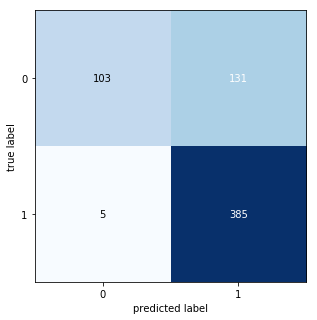

In [16]:
# Libreria mlxtend para dibujo con diseño de la matriz de confusion
CM = confusion_matrix(y_test2, y_pred2)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [24]:
# Para ahorrar tiempo cuando posteriormente desee usarlo, guardo el modelo entrenado
joblib.dump(clf2, './data/chest_xray/clf2.pkl')


['./data/chest_xray/clf2.pkl']

In [17]:
# Creo un dataframe para los modelos de validacion y sus prediciones

# Preparo dataframe de resultados
resultados_val = pd.DataFrame(columns=['y_val2', 'y_val3', 'svm2'])

# Incorporo la columna original
resultados_val['y_val2'] = y_val2
resultados_val['y_val3'] = y_val3

# Preparo dataset de validacion y uso modelo svm para predicciones poniendolas en dataframe
X_val_pca = pca2.transform(X_val2_svm)
resultados_val['svm2'] = clf2.predict(X_val_pca)

# Muestro resultados de la prediccion
resultados_val.head(20)

y_val2 y_val3 svm2
0       0      0    1
1       0      0    1
2       0      0    0
3       0      0    0
4       0      0    0
5       0      0    0
6       0      0    0
7       0      0    0
8       1      1    1
9       1      1    1
10      1      1    1
11      1      1    1
12      1      1    1
13      1      1    1
14      1      1    1
15      1      1    1

In [18]:
# Entreno un clasificador SVM con los mejores parametros obenidos para 3 clases

print("\nProbando el clasificador SVM con el conjunto de entrenamiento para 3 clases")

# Inicia cronometro
start_time = time.time()

# Defino un diccionario de parametros para probar (SVM tuneado)
param_grid = {'C': [1e3], 'gamma': [0.005]}

# Uso los mejores parametros de las pruebas
clf3 = SVC(kernel='rbf', class_weight='balanced', C=1000, gamma=0.005)

# Modelo de entrenamiento
clf3 = clf3.fit(X_train3_pca, y_train3)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("El entrenamiento del SVM tuneado ha tardado: ", dt, "segundos (", round(dt/60,1) , "minutos)")


Probando el clasificador SVM con el conjunto de entrenamiento para 3 clases
El entrenamiento del SVM tuneado ha tardado:  2.44 segundos ( 0.0 minutos)


In [19]:
# #############################################################################
# Pruebo el modelo SVM con el conjunto de datos de prueba para 3 clases

print("\nPrediciendo los nombres de las personas en el conjunto de prueba")

# Inicia cronometro
start_time = time.time()

# Uso el modelo para predecir el diagnostico en el conjunto de prueba tras PCA
y_pred3 = clf3.predict(X_test3_pca)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("La prediccion con el modelo SVM tarda: ", dt, "segundos (", round(dt/60,1) , "minutos)")


# Informe de rendimiento sobre el conjunto de prueba
print("\nInforme de rendimiento para el conjunto de prueba:\n")
print(classification_report(y_test3, y_pred3, target_names=['NONE', 'BACTERIA', 'VIRUS']))

print("\nMatriz de confusion para el conjunto de prueba:\n")
print(confusion_matrix(y_test3, y_pred3))


Prediciendo los nombres de las personas en el conjunto de prueba
La prediccion con el modelo SVM tarda:  0.29 segundos ( 0.0 minutos)

Informe de rendimiento para el conjunto de prueba:

              precision    recall  f1-score   support

        NONE       0.96      0.37      0.53       234
    BACTERIA       0.76      0.88      0.82       242
       VIRUS       0.45      0.77      0.57       148

   micro avg       0.66      0.66      0.66       624
   macro avg       0.72      0.67      0.64       624
weighted avg       0.76      0.66      0.65       624


Matriz de confusion para el conjunto de prueba:

[[ 86  36 112]
 [  1 213  28]
 [  3  31 114]]


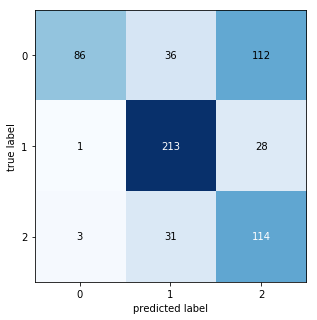

In [20]:
# Libreria mlxtend para dibujo con diseño de la matriz de confusion
CM = confusion_matrix(y_test3, y_pred3)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [25]:
# Para ahorrar tiempo cuando posteriormente desee usarlo, guardo el modelo entrenado
joblib.dump(clf3, './data/chest_xray/clf3.pkl')


['./data/chest_xray/clf3.pkl']

In [26]:
# Añado los resultados de prediccion del conjunto de validacion al dataframe

# Preparo dataset de validacion y uso modelo svm para predicciones poniendolas en dataframe
X_val_pca = pca3.transform(X_val3_svm)
resultados_val['svm3'] = clf3.predict(X_val_pca)

# Muestro resultados de la prediccion
resultados_val.head(20)

y_val2 y_val3 svm2 svm3
0       0      0    1    2
1       0      0    1    1
2       0      0    0    0
3       0      0    0    0
4       0      0    0    0
5       0      0    0    0
6       0      0    0    0
7       0      0    0    0
8       1      1    1    1
9       1      1    1    1
10      1      1    1    2
11      1      1    1    2
12      1      1    1    2
13      1      1    1    1
14      1      1    1    1
15      1      1    1    1

**Modelos de aprendizaje profundo**

Incorporo los modelos con mejores resultados de los probados, las redes convolucionales separables, tanto para la clasificación en 2 como en 3 clases.

Dado que las pruebas se realizaron con un número muy reducido de épocas de entrenamiento, realizo previamente a cada uno un autotuning de los parámetros epoch y batch_size que permitan obtener la mejor combinación para cada uno.

Continúo obteniendo las métricas de cada modelo probado, y realizando predicciones con el conjunto de datos de prueba (carpeta VAL) que acumulo en el dataframe de resultados.

In [27]:
#############################################################################
## PREPARACION CONJUNTO DE DATOS PARA MODELOS DE REDES NEURONALES CONVOLUCIONADAS

# PARA 2 CLASES

#Formato de imagenes en los conjuntos de carga
print("Formato imagenes en conjuntos de carga 2 clases")
print(X_train2.shape)
print(X_test2.shape)
print(X_val2.shape)

# Aseguro las dimensiones del array como imagenes de entrada para el modelo
X_train2=X_train2.reshape(2682,3,150,150)
X_test2=X_test2.reshape(624,3,150,150)
X_val2=X_val2.reshape(16,3,150,150)

# Compruebo
print("Formato imagenes para entrada del modelo 2 clases")
print(X_train2.shape)
print(X_test2.shape)
print(X_val2.shape)

# Compruebo
print("Formato etiquetas 2 clases")
print(y_train2.shape)
print(y_test2.shape)
print(y_val2.shape)


# PARA 3 CLASES

#Formato de imagenes en los conjuntos de carga
print("Formato imagenes en conjuntos de carga 3 clases")
print(X_train3.shape)
print(X_test3.shape)
print(X_val3.shape)

# Aseguro las dimensiones del array como imagenes de entrada para el modelo
X_train3=X_train3.reshape(4023,3,150,150)
X_test3=X_test3.reshape(624,3,150,150)
X_val3=X_val3.reshape(16,3,150,150)

# Compruebo
print("Formato imagenes para entrada del modelo 3 clases")
print(X_train3.shape)
print(X_test3.shape)
print(X_val3.shape)

# Compruebo
print("Formato etiquetas 3 clases")
print(y_train3.shape)
print(y_test3.shape)
print(y_val3.shape)

Formato imagenes en conjuntos de carga 2 clases
(2682, 150, 150, 3)
(624, 150, 150, 3)
(16, 150, 150, 3)
Formato imagenes para entrada del modelo 2 clases
(2682, 3, 150, 150)
(624, 3, 150, 150)
(16, 3, 150, 150)
Formato etiquetas 2 clases
(2682,)
(624,)
(16,)
Formato imagenes en conjuntos de carga 3 clases
(4023, 150, 150, 3)
(624, 150, 150, 3)
(16, 150, 150, 3)
Formato imagenes para entrada del modelo 3 clases
(4023, 3, 150, 150)
(624, 3, 150, 150)
(16, 3, 150, 150)
Formato etiquetas 3 clases
(4023,)
(624,)
(16,)


In [28]:
# Convierto los conjuntos de datos en los array de etiquetas a categoricos

# Uso 2 clases (clasificacion binaria) porque el campo diagnostico tiene 2 valores. 

y_train2 = to_categorical(y_train2, num_classes=2, dtype='int') # Solo toma numeros, por defecto enteros
y_test2 = to_categorical(y_test2, num_classes=2, dtype='int')
y_val2 =  to_categorical(y_val2, num_classes=2, dtype='int')

print(y_train2.shape)
print(y_test2.shape)
print(y_val2.shape)


# Con el modelo de patogenos, 3 clases

y_train3 = to_categorical(y_train3, num_classes=3, dtype='int') # Solo toma numeros, por defecto enteros
y_test3 = to_categorical(y_test3, num_classes=3, dtype='int')
y_val3 =  to_categorical(y_val3, num_classes=3, dtype='int')

print(y_train3.shape)
print(y_test3.shape)
print(y_val3.shape)



(2682, 2)
(624, 2)
(16, 2)
(4023, 3)
(624, 3)
(16, 3)


In [29]:
# indico que los nucleos convolucionales tengan la misma forma
K.set_image_dim_ordering('th')


In [26]:
## ENTRENAMIENTO RN CONVOLUCIONAL SEPARABLE BASICO 2 CLASES - TUNEADO EPOCH / BATCHSIZE

# Fijo una semilla para tener reproductibilidad
seed = 7
np.random.seed(seed)

# Defino funcion para crear un modelo
def creador_modelo():
    model_auto = Sequential()
    model_auto.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
    model_auto.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first'))
    model_auto.add(SeparableConv2D(64, (3,3), activation='relu', padding='same'))
    model_auto.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first'))
    model_auto.add(SeparableConv2D(64, (3,3), activation='relu', padding='same'))
    model_auto.add(BatchNormalization())
    model_auto.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first'))
    model_auto.add(SeparableConv2D(128, (3,3), activation='relu', padding='same'))
    model_auto.add(BatchNormalization())
    model_auto.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first'))
    model_auto.add(Flatten())
    model_auto.add(Dense(64, activation='relu')) # Capa con funcion de activacion tuneada
    model_auto.add(Dropout(0.4))
    model_auto.add(Dense(2 , activation='softmax'))
    model_auto.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001, decay=2e-5), metrics=['accuracy'])
    return model_auto

# Recreo el modelo cada iteracion para evitar sobre entrenamientos
model_basico_auto2 = KerasClassifier(build_fn=creador_modelo, verbose=1)

# Defino parametros a probar
batch_size = [64, 128]
epochs = [4, 6]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# Inicia cronometro
start_time = time.time()

# grid2 = GridSearchCV(estimator=model_basico_auto2, param_grid=param_grid, n_jobs=-1)
grid2 = GridSearchCV(estimator=model_basico_auto2, param_grid=param_grid, n_jobs=8, pre_dispatch=16)
grid_result2 = grid2.fit(X_train2, y_train2)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("\nEl entrenamiento de este modelo tardó: ", dt, "segundos (", round(dt/60,1) , "minutos)")


# summarize results
print("\nMejor: %f usando %s" % (grid_result2.best_score_, grid_result2.best_params_))
means2 = grid_result2.cv_results_['mean_test_score']
stds2 = grid_result2.cv_results_['std_test_score']
params2 = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means2, stds2, params2):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/6
2682/2682 [==============================] - 83s 31ms/step - loss: 0.5580 - acc: 0.7334
Epoch 2/6
2682/2682 [==============================] - 82s 31ms/step - loss: 0.3416 - acc: 0.8695
Epoch 3/6
2682/2682 [==============================] - 82s 31ms/step - loss: 0.2441 - acc: 0.9120
Epoch 4/6
2682/2682 [==============================] - 83s 31ms/step - loss: 0.2041 - acc: 0.9236
Epoch 5/6
2682/2682 [==============================] - 82s 30ms/step - loss: 0.1788 - acc: 0.9385
Epoch 6/6
2682/2682 [==============================] - 82s 31ms/step - loss: 0.1631 - acc: 0.9396

El entrenamiento de este modelo tardó:  772.4 segundos ( 12.9 minutos)

Mejor: 0.873602 usando {'batch_size': 64, 'epochs': 6}
0.872856 (0.041355) with: {'batch_size': 64, 'epochs': 4}
0.873602 (0.041099) with: {'batch_size': 64, 'epochs': 6}
0.818419 (0.065200) with: {'batch_size': 128, 'epochs': 4}
0.586503 (0.306748) with: {'batch_size': 128, 'epochs': 6}


In [30]:
####################################################
# Definicion de modelo_base para RN Convolucional Separable de 2 clases

# Introduzco datos con una convolucional y reduzco con maxpooling
# Aplico convoluciones separables en profundidad para aprender detalles estirando canales
# Para reducir numero de parametros y acelerar calculos simplificando arquitectura y reduciendo sobreajuste
# https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728

# Repito la estrategia 3 veces incrementando el numero de filtros cada vez para concentrar detalles
# Uso normalización en las dos ultimas

# Tras el aprendizaje de los detalles, incluyo formateador con Flatten y el clasificador con dense

model_basico2 = Sequential()
model_basico2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
model_basico2.add(MaxPooling2D(pool_size=(2, 2)))

model_basico2.add(SeparableConv2D(64, (3,3), activation='relu', padding='same'))
model_basico2.add(MaxPooling2D(pool_size=(2, 2)))

model_basico2.add(SeparableConv2D(64, (3,3), activation='relu', padding='same'))
model_basico2.add(BatchNormalization())
model_basico2.add(MaxPooling2D(pool_size=(2, 2)))

model_basico2.add(SeparableConv2D(128, (3,3), activation='relu', padding='same'))
model_basico2.add(BatchNormalization())
model_basico2.add(MaxPooling2D(pool_size=(2, 2)))

# Formateo de datos con Flatten
model_basico2.add(Flatten())

# Clasificador con capas totalmente conectadas
model_basico2.add(Dense(64, activation='relu')) # Capa con funcion de activacion tuneada
model_basico2.add(Dropout(0.4))
model_basico2.add(Dense(2 , activation='softmax'))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [31]:
# Compilacion para 2 clases
# Uso binary_crossentropy porque es una clasificación de 2 clases excluyentes.
model_basico2.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001, decay=2e-5), metrics=['accuracy'])

# Resumen del modelo
print(model_basico2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 150, 150)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 75, 75)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 64, 75, 75)        4736      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 37, 37)        0         
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 64, 37, 37)        4736      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 37, 37)        148       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 18, 18)        0         
__________

In [32]:
## ENTRENAMIENTO MODELO RN CONVOLUCIONAL SEPARABLE BASICO 2 CLASES OPTIMIZADO

## ANTES DE EJECUTAR EN LA CONSOLA DE CONDA HACER tensorboard --logdir <<pathlogdir>>
## por ejmplo:    tensorboard --logdir c:\Users\Jose\logs\tensorboard

# Parametros de entrenamiento con los resultados prueba tunning anterior
batch_size = 64
epochs = 6

# DEFINO CALLBACKS

# Habilito una ruta y un archivo para guardar los pesos de entrenamiento de la red
## ESPECIFICO PARA ESTA RED
filepath="./checkpoints/chest_xray_res2_weights_basico.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Definimos reducción de la tasa de aprendizaje ReduceLROnPlateau cuando cerca de minimo
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.001, patience=1, verbose=1)

# inicializar tensorboardcolab
tensorboard = TensorBoard(log_dir='./log/tensorboard', histogram_freq=0, write_graph=True, write_images=False)


# Entrenamiento del modelo
# Inicia cronometro
start_time = time.time()

# Entreno el modelo
# Sin TensorBoard
# history_basico2 = model_basico2.fit(X_train2, y_train2, validation_data = (X_test2 , y_test2), callbacks=[lr_reduce,checkpoint], epochs=epochs)

history_basico2 = model_basico2.fit(X_train2, y_train2, validation_data = (X_test2 , y_test2), callbacks=[lr_reduce, checkpoint, tensorboard], epochs=epochs)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("El entrenamiento de este modelo tardó: ", dt, "segundos (", round(dt/60,1) , "minutos)")

Instructions for updating:
Use tf.cast instead.
Train on 2682 samples, validate on 624 samples
Epoch 1/6
2682/2682 [==============================] - 90s 34ms/step - loss: 0.4736 - acc: 0.7864 - val_loss: 0.4311 - val_acc: 0.7981

Epoch 00001: val_acc improved from -inf to 0.79808, saving model to ./checkpoints/chest_xray_res2_weights_basico.hdf5
Epoch 2/6
2682/2682 [==============================] - 88s 33ms/step - loss: 0.2384 - acc: 0.9045 - val_loss: 0.4224 - val_acc: 0.7869

Epoch 00002: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00002: val_acc did not improve from 0.79808
Epoch 3/6
2682/2682 [==============================] - 90s 34ms/step - loss: 0.1823 - acc: 0.9344 - val_loss: 0.5059 - val_acc: 0.7644

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00003: val_acc did not improve from 0.79808
Epoch 4/6
2682/2682 [==============================] - 89s 33ms/step - loss: 0.1777 - acc: 0.9348 - val_loss: 0.5100 

In [33]:
# Definimos variables para guardar los resultados del modelo de basico entrenado
acc_bas2 = history_basico2.history['acc']
val_acc_bas2 = history_basico2.history['val_acc']
loss_bas2 = history_basico2.history['loss']
val_loss_bas2 = history_basico2.history['val_loss']


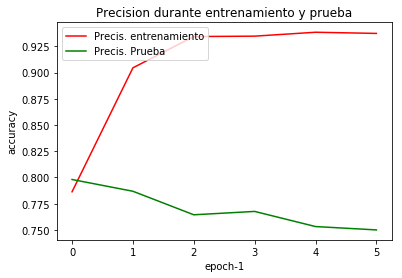

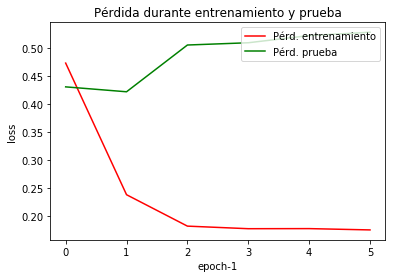

<Figure size 432x288 with 0 Axes>

In [34]:
# Representacion de metricas para el modelo de basico durante el entrenamiento

# Precision
plt.plot(acc_bas2, label='Precis. entrenamiento', color='Red')
plt.plot(val_acc_bas2, label='Precis. Prueba', color='Green')
plt.title('Precision durante entrenamiento y prueba')
plt.ylabel('accuracy')
plt.xlabel('epoch-1')
plt.legend(fontsize=10, loc='upper left')
plt.figure()

# Perdida
plt.plot(loss_bas2, label='Pérd. entrenamiento', color='Red')
plt.plot(val_loss_bas2, label='Pérd. prueba', color='Green')
plt.title('Pérdida durante entrenamiento y prueba')
plt.ylabel('loss')
plt.xlabel('epoch-1')
plt.legend(fontsize=10, loc='upper right')
plt.figure()

# Represento
plt.show()

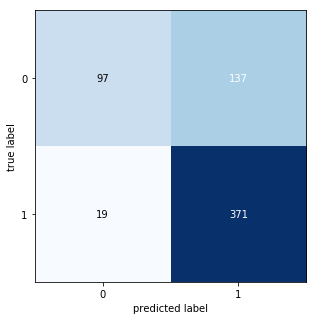

In [35]:
pred2 = model_basico2.predict(X_test2)
pred2 = np.argmax(pred2,axis = 1) 
y_true2 = np.argmax(y_test2,axis = 1)

# Libreria mlxtend para dibujo rapido de la matriz
CM = confusion_matrix(y_true2, pred2)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [36]:
## A REVISAR CON LOS RESULTADOS DE LA MATRIZ

print(classification_report(y_true2, pred2, target_names=['NORMAL', 'PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.84      0.41      0.55       234
   PNEUMONIA       0.73      0.95      0.83       390

   micro avg       0.75      0.75      0.75       624
   macro avg       0.78      0.68      0.69       624
weighted avg       0.77      0.75      0.72       624



In [37]:
# Calculo rendimiento del segundo modelo entrenado
score_2= model_basico2.evaluate(X_val2, y_val2, batch_size=batch_size, verbose=1)
# Informo rendimiento
print(model_basico2.metrics_names)
print("Test score - loss:", score_2[0])
print('Test score - accuracy:', score_2[1])

16/16 [==============================] - 0s 12ms/step
['loss', 'acc']
Test score - loss: 0.3531031608581543
Test score - accuracy: 0.875


In [38]:
# Para ahorrar tiempo cuando posteriormente desee usarlo, guardo el modelo entrenado
model_basico2_json = model_basico2.to_json()
open('./data/chest_xray/model_basico2.json', 'w').write(model_basico2_json)

# Guardo tambien los pesos aprendidos por la red profunda que he creado con este entrenamiento
model_basico2.save_weights('./data/chest_xray/model_basico2.h5', overwrite=True)

In [39]:
### Coloco las predicciones de este modelo en el dataframe de resultados

# La prediccion de la RN es de dos columnas (probabilidad)
print('Probabilidades de diagnostico positivo')
print((model_basico2.predict(X_val2)[:,1]))
# El unico error de este modelo aparece con una probabilidad muy alta, no puede filtrarse
# Tampoco puede usarse el svm3 para eliminarlo, aunque si un voting de los dos modelos

# Tomo la segunda y hago redondeo simple
resultados_val['convsep2'] = (np.round_((model_basico2.predict(X_val2)[:,1]), decimals=0).astype(int))

# Muestro resultados de la prediccion
resultados_val.head(20)

Probabilidades de diagnostico positivo
[0.5593185  0.258334   0.06901566 0.2516072  0.89823407 0.11662957
 0.04919548 0.17529644 0.9189156  0.9612376  0.9724328  0.62820405
 0.8122697  0.9838943  0.6360548  0.7991685 ]


y_val2 y_val3 svm2 svm3  convsep2
0       0      0    1    2         1
1       0      0    1    1         0
2       0      0    0    0         0
3       0      0    0    0         0
4       0      0    0    0         1
5       0      0    0    0         0
6       0      0    0    0         0
7       0      0    0    0         0
8       1      1    1    1         1
9       1      1    1    1         1
10      1      1    1    2         1
11      1      1    1    2         1
12      1      1    1    2         1
13      1      1    1    1         1
14      1      1    1    1         1
15      1      1    1    1         1

In [36]:
## ENTRENAMIENTO RN CONVOLUCIONAL SEPARABLE BASICO 3 CLASES - TUNEADO EPOCH / BATCHSIZE

# Fijo una semilla para tener reproductibilidad
seed = 7
np.random.seed(seed)

# Defino funcion para crear un modelo
def creador_modelo():
    model_auto = Sequential()
    model_auto.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
    model_auto.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first'))
    model_auto.add(SeparableConv2D(64, (3,3), activation='relu', padding='same'))
    model_auto.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first'))
    model_auto.add(SeparableConv2D(64, (3,3), activation='relu', padding='same'))
    model_auto.add(BatchNormalization())
    model_auto.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first'))
    model_auto.add(SeparableConv2D(128, (3,3), activation='relu', padding='same'))
    model_auto.add(BatchNormalization())
    model_auto.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first'))
    model_auto.add(Flatten())
    model_auto.add(Dense(64, activation='relu')) # Capa con funcion de activacion tuneada
    model_auto.add(Dropout(0.4))
    model_auto.add(Dense(3 , activation='softmax'))
    model_auto.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001, decay=1e-5), metrics=['accuracy'])
    return model_auto

# Recreo el modelo cada iteracion para evitar sobre entrenamientos
model_basico_auto3 = KerasClassifier(build_fn=creador_modelo, verbose=1)

# Defino parametros a probar
batch_size = [128, 256]
epochs = [4, 6]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# Inicia cronometro
start_time = time.time()

grid3 = GridSearchCV(estimator=model_basico_auto3, param_grid=param_grid, n_jobs=8, pre_dispatch=16)
grid_result3 = grid3.fit(X_train3, y_train3)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("\nEl entrenamiento de este modelo tardó: ", dt, "segundos (", round(dt/60,1) , "minutos)")

# summarize results
print("\nMejor: %f usando %s" % (grid_result3.best_score_, grid_result3.best_params_))
means3 = grid_result3.cv_results_['mean_test_score']
stds3 = grid_result3.cv_results_['std_test_score']
params3 = grid_result3.cv_results_['params']
for mean, stdev, param in zip(means3, stds3, params3):
    print("%f (%f) with: %r" % (mean, stdev, param))

D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Epoch 1/4
4023/4023 [==============================] - 126s 31ms/step - loss: 1.0056 - acc: 0.4954
Epoch 2/4
4023/4023 [==============================] - 123s 31ms/step - loss: 0.8210 - acc: 0.6301
Epoch 3/4
4023/4023 [==============================] - 122s 30ms/step - loss: 0.7183 - acc: 0.6781
Epoch 4/4
4023/4023 [==============================] - 124s 31ms/step - loss: 0.6692 - acc: 0.6967

El entrenamiento de este modelo tardó:  942.93 segundos ( 15.7 minutos)

Mejor: 0.000000 usando {'batch_size': 128, 'epochs': 4}
0.000000 (0.000000) with: {'batch_size': 128, 'epochs': 4}
0.000000 (0.000000) with: {'batch_size': 128, 'epochs': 6}
0.000000 (0.000000) with: {'batch_size': 256, 'epochs': 4}
0.000000 (0.000000) with: {'batch_size': 256, 'epochs': 6}


In [40]:
####################################################
# Definicion de modelo_base para RN Convolucional Separable de 3 clases

# Introduzco datos con una convolucional y reduzco con maxpooling
# Aplico convoluciones separables en profundidad para aprender detalles estirando canales
# Para reducir numero de parametros y acelerar calculos simplificando arquitectura y reduciendo sobreajuste
# https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728

# Repito la estrategia 3 veces incrementando el numero de filtros cada vez para concentrar detalles
# Uso normalización en las dos ultimas

# Tras el aprendizaje de los detalles, incluyo formateador con Flatten y el clasificador con dense

model_basico3 = Sequential()
model_basico3.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
model_basico3.add(MaxPooling2D(pool_size=(2, 2)))

model_basico3.add(SeparableConv2D(64, (3,3), activation='relu', padding='same'))
model_basico3.add(MaxPooling2D(pool_size=(2, 2)))

model_basico3.add(SeparableConv2D(64, (3,3), activation='relu', padding='same'))
model_basico3.add(BatchNormalization())
model_basico3.add(MaxPooling2D(pool_size=(2, 2)))

model_basico3.add(SeparableConv2D(128, (3,3), activation='relu', padding='same'))
model_basico3.add(BatchNormalization())
model_basico3.add(MaxPooling2D(pool_size=(2, 2)))

# Formateo de datos con Flatten
model_basico3.add(Flatten())

# Clasificador con capas totalmente conectadas
model_basico3.add(Dense(64, activation='relu')) # Capa con funcion de activacion tuneada
model_basico3.add(Dropout(0.4))
model_basico3.add(Dense(3 , activation='softmax'))

In [41]:
# Compilacion para 3 clases
# Uso categorical_crossentropy porque es una clasificación de 3 clases excluyentes.
model_basico3.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001, decay=1e-5), metrics=['accuracy'])

# Resumen del modelo
print(model_basico3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 150, 150)      1792      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 75, 75)        0         
_________________________________________________________________
separable_conv2d_4 (Separabl (None, 64, 75, 75)        4736      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 37, 37)        0         
_________________________________________________________________
separable_conv2d_5 (Separabl (None, 64, 37, 37)        4736      
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 37, 37)        148       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 18, 18)        0         
__________

In [42]:
## ENTRENAMIENTO MODELO RN CONVOLUCIONAL SEPARABLE BASICO 3 CLASES

# Parametros de entrenamiento con los resultados de la prueba tunning anterior
batch_size = 128
epochs = 4

# DEFINO CALLBACKS

# Habilito una ruta y un archivo para guardar los pesos de entrenamiento de la red
## ESPECIFICO PARA ESTA RED
filepath="./checkpoints/chest_xray_res3_weights_basico.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Definimos reducción de la tasa de aprendizaje ReduceLROnPlateau cuando cerca de minimo
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.001, patience=1, verbose=1)

# inicializar tensorboardcolab
tensorboard = TensorBoard(log_dir='./log/tensorboard', histogram_freq=0, write_graph=True, write_images=False)


# Entrenamiento del modelo
# Inicia cronometro
start_time = time.time()

# Entreno el modelo
# Sin TensorBoard
# history_basico3 = model_basico3.fit(X_train3, y_train3, validation_data = (X_test3 , y_test3), callbacks=[lr_reduce,checkpoint], epochs=epochs)

history_basico3 = model_basico3.fit(X_train3, y_train3, validation_data = (X_test3 , y_test3), callbacks=[lr_reduce,checkpoint, tensorboard], epochs=epochs)


# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("El entrenamiento de este modelo tardó: ", dt, "segundos (", round(dt/60,1) , "minutos)")

Train on 4023 samples, validate on 624 samples
Epoch 1/4
4023/4023 [==============================] - 130s 32ms/step - loss: 0.8751 - acc: 0.5896 - val_loss: 0.8634 - val_acc: 0.5112

Epoch 00001: val_acc improved from -inf to 0.51122, saving model to ./checkpoints/chest_xray_res3_weights_basico.hdf5
Epoch 2/4
4023/4023 [==============================] - 130s 32ms/step - loss: 0.6518 - acc: 0.7044 - val_loss: 1.1000 - val_acc: 0.6218

Epoch 00002: val_acc improved from 0.51122 to 0.62179, saving model to ./checkpoints/chest_xray_res3_weights_basico.hdf5
Epoch 3/4
4023/4023 [==============================] - 130s 32ms/step - loss: 0.5931 - acc: 0.7430 - val_loss: 1.1976 - val_acc: 0.6346

Epoch 00003: val_acc improved from 0.62179 to 0.63462, saving model to ./checkpoints/chest_xray_res3_weights_basico.hdf5
Epoch 4/4
4023/4023 [==============================] - 130s 32ms/step - loss: 0.5543 - acc: 0.7489 - val_loss: 0.9957 - val_acc: 0.6971

Epoch 00004: val_acc improved from 0.63462 to

In [43]:
# Definimos variables para guardar los resultados del modelo de basico entrenado
acc_bas3 = history_basico3.history['acc']
val_acc_bas3 = history_basico3.history['val_acc']
loss_bas3 = history_basico3.history['loss']
val_loss_bas3 = history_basico3.history['val_loss']


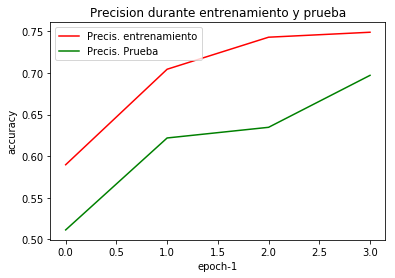

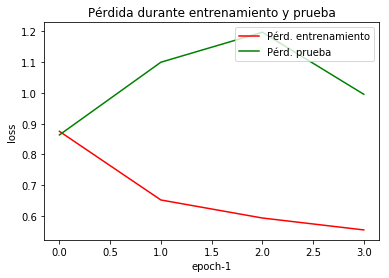

<Figure size 432x288 with 0 Axes>

In [44]:
# Representacion de metricas para el modelo de basico durante el entrenamiento

# Precision
plt.plot(acc_bas3, label='Precis. entrenamiento', color='Red')
plt.plot(val_acc_bas3, label='Precis. Prueba', color='Green')
plt.title('Precision durante entrenamiento y prueba')
plt.ylabel('accuracy')
plt.xlabel('epoch-1')
plt.legend(fontsize=10, loc='upper left')
plt.figure()

# Perdida
plt.plot(loss_bas3, label='Pérd. entrenamiento', color='Red')
plt.plot(val_loss_bas3, label='Pérd. prueba', color='Green')
plt.title('Pérdida durante entrenamiento y prueba')
plt.ylabel('loss')
plt.xlabel('epoch-1')
plt.legend(fontsize=10, loc='upper right')
plt.figure()

# Represento
plt.show()

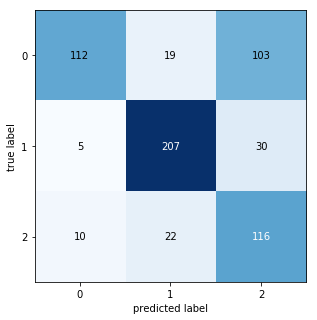

In [45]:
pred3 = model_basico3.predict(X_test3)
pred3 = np.argmax(pred3,axis = 1) 
y_true3 = np.argmax(y_test3,axis = 1)

# Libreria mlxtend para dibujo rapido de la matriz
CM = confusion_matrix(y_true3, pred3)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [46]:
## A REVISAR CON LOS RESULTADOS DE LA MATRIZ

print(classification_report(y_true3, pred3, target_names=['NONE', 'BACTERIA', 'VIRUS']))

              precision    recall  f1-score   support

        NONE       0.88      0.48      0.62       234
    BACTERIA       0.83      0.86      0.84       242
       VIRUS       0.47      0.78      0.58       148

   micro avg       0.70      0.70      0.70       624
   macro avg       0.73      0.71      0.68       624
weighted avg       0.76      0.70      0.70       624



In [47]:
# Calculo rendimiento del segundo modelo entrenado
score_3 = model_basico3.evaluate(X_val3, y_val3, batch_size=batch_size, verbose=1)
# Informo rendimiento
print("Test score - loss:", score_3[0])
print('Test score - accuracy:', score_3[1])


16/16 [==============================] - 0s 12ms/step
Test score - loss: 0.9463350772857666
Test score - accuracy: 0.5625


In [48]:
# Para ahorrar tiempo cuando posteriormente desee usarlo, guardo el modelo entrenado
model_basico3_json = model_basico3.to_json()
open('./data/chest_xray/model_basico3.json', 'w').write(model_basico3_json)

# Guardo tambien los pesos aprendidos por la red profunda que he creado con este entrenamiento
model_basico3.save_weights('./data/chest_xray/model_basico3.h5', overwrite=True)

In [49]:
### Coloco las predicciones de este modelo en el dataframe de resultados

# La prediccion de la RN es de tres columnas (probabilidad)
print('Probabilidades de diagnostico positivo')
pred = model_basico3.predict(X_val3)
print(pred)

# Localizo para cada fila el id de la columna que contiene el valor maximo
print(np.argmax(pred, axis=1))

# Tomo la segunda y hago redondeo simple
resultados_val['convsep3'] = np.argmax(pred, axis=1)

# Muestro resultados de la prediccion
resultados_val.head(20)

# Este modelo tiene muchos errores pero no puede filtrarse por un valor minimo
# Tampoco puede usarse el svm3 para compensarlo

Probabilidades de diagnostico positivo
[[0.40688017 0.07563359 0.5174863 ]
 [0.7544789  0.13741247 0.1081086 ]
 [0.8993741  0.0139305  0.08669545]
 [0.775806   0.10159921 0.12259486]
 [0.05878385 0.44255406 0.49866205]
 [0.8112002  0.01361009 0.1751897 ]
 [0.9315613  0.02929268 0.03914607]
 [0.88825923 0.03357869 0.07816211]
 [0.02497301 0.5743506  0.40067643]
 [0.07130502 0.5025414  0.42615354]
 [0.00890797 0.2049756  0.7861165 ]
 [0.13831508 0.17826141 0.6834235 ]
 [0.06979123 0.14372532 0.78648347]
 [0.11586053 0.5266301  0.35750932]
 [0.55086994 0.1648102  0.28431988]
 [0.04115315 0.23884428 0.72000265]]
[2 0 0 0 2 0 0 0 1 1 2 2 2 1 0 2]


y_val2 y_val3 svm2 svm3  convsep2  convsep3
0       0      0    1    2         1         2
1       0      0    1    1         0         0
2       0      0    0    0         0         0
3       0      0    0    0         0         0
4       0      0    0    0         1         2
5       0      0    0    0         0         0
6       0      0    0    0         0         0
7       0      0    0    0         0         0
8       1      1    1    1         1         1
9       1      1    1    1         1         1
10      1      1    1    2         1         2
11      1      1    1    2         1         2
12      1      1    1    2         1         2
13      1      1    1    1         1         1
14      1      1    1    1         1         0
15      1      1    1    1         1         2

**Ensemble de modelos**

Realizo un ensemble manual de los modelos seleccionados. No uso una función automática sino las predicciones obtenidas en el dataframe de resultados, ya que los datos de entrada no tienen las mismas dimensiones en cada uno de los modelos, al combinarse el clásico SVM con la red convolucional separable.

El ensemble se realiza asignando pesos a la predicción de cada modelo y seleccionando la combinación que más se aproxima.

El resultado del ensemble se almacena también como otra columna del dataset de resultados, tanto para 2 como para 3 clases.

In [50]:
### ENSEMBLE MANUAL TIPO VOTING para 2 clases (no se puede automatizar por diferente formato de los datos)

# Creo lista vacia para clasificador por filas
voting_2 =[]

# Analisis por filas
val0_fila = 0
val1_fila = 0

for indice_fila, fila in resultados_val.iterrows():
    
    # SVM2
    peso = 1
    if fila[2] == 0:
        val0_fila = val0_fila + peso
    else:
        val1_fila = val1_fila + peso
        
    # SVM3
    peso = 2
    if fila[3] == 0:
        val0_fila = val0_fila + peso
    else:
        val1_fila = val1_fila + peso

    # ConvSep2
    peso = 3
    if fila[4] == 0:
        val0_fila = val0_fila + peso
    else:
        val1_fila = val1_fila + peso
    
    # ConvSep3
    peso = 2
    if fila[5] == 0:
        val0_fila = val0_fila + peso
    else:
        val1_fila = val1_fila + peso


    # Balance para poner el valor dominante en la lista de resultados
    if val0_fila > val1_fila:
        voting_2.append(0)
    else:
        voting_2.append(1)
        
    val0_fila = 0
    val1_fila = 0

print (voting_2)

# Tomo la segunda y hago redondeo simple
resultados_val['voting2'] = voting_2

# Muestro resultados de la prediccion
resultados_val.head(20)

[1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]


y_val2 y_val3 svm2 svm3  convsep2  convsep3  voting2
0       0      0    1    2         1         2        1
1       0      0    1    1         0         0        0
2       0      0    0    0         0         0        0
3       0      0    0    0         0         0        0
4       0      0    0    0         1         2        1
5       0      0    0    0         0         0        0
6       0      0    0    0         0         0        0
7       0      0    0    0         0         0        0
8       1      1    1    1         1         1        1
9       1      1    1    1         1         1        1
10      1      1    1    2         1         2        1
11      1      1    1    2         1         2        1
12      1      1    1    2         1         2        1
13      1      1    1    1         1         1        1
14      1      1    1    1         1         0        1
15      1      1    1    1         1         2        1

In [51]:
### ENSEMBLE MANUAL TIPO VOTING para 3 clases (no se puede automatizar por diferente formato de los datos)

# Creo lista vacia para clasificador por filas
voting_3 =[]

# Analisis por filas
val0_fila = 0
val1_fila = 0
val2_fila = 0

for indice_fila, fila in resultados_val.iterrows():
    
    # SVM2
    peso = 3
    if fila[2] == 0:
        val0_fila = val0_fila + peso
    else:
        val1_fila = val1_fila + peso
        
    # SVM3
    peso = 2
    if fila[3] == 0:
        val0_fila = val0_fila + peso
    elif fila[3] == 1:
        val1_fila = val1_fila + peso
    else:
        val2_fila = val2_fila + peso

        
    # ConvSep2
    peso = 3
    if fila[4] == 0:
        val0_fila = val0_fila + peso
    else:
        val1_fila = val1_fila + peso
    
    # ConvSep3
    peso = 2
    if fila[5] == 0:
        val0_fila = val0_fila + peso
    elif fila[5] == 1:
        val1_fila = val1_fila + peso
    else:
        val2_fila = val2_fila + peso


    # Balance para poner el valor dominante en la lista de resultados
    if val0_fila > val1_fila and val0_fila > val2_fila:
        voting_3.append(0)
    elif val1_fila > val2_fila:
        voting_3.append(1)
    else:
        voting_3.append(2)
        
    val0_fila = 0
    val1_fila = 0
    val2_fila = 0

print (voting_3)

# Tomo la segunda y hago redondeo simple
resultados_val['voting3'] = voting_3

# Muestro resultados de la prediccion
resultados_val.head(20)

[1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]


y_val2 y_val3 svm2 svm3  convsep2  convsep3  voting2  voting3
0       0      0    1    2         1         2        1        1
1       0      0    1    1         0         0        0        0
2       0      0    0    0         0         0        0        0
3       0      0    0    0         0         0        0        0
4       0      0    0    0         1         2        1        1
5       0      0    0    0         0         0        0        0
6       0      0    0    0         0         0        0        0
7       0      0    0    0         0         0        0        0
8       1      1    1    1         1         1        1        1
9       1      1    1    1         1         1        1        1
10      1      1    1    2         1         2        1        1
11      1      1    1    2         1         2        1        1
12      1      1    1    2         1         2        1        1
13      1      1    1    1         1         1        1        1
14      1      1    1    1         1         0        1        1
15      1      1    1    1         1         2        1        1

**Métricas**

Obtengo las matrices de confusión y las métricas para los ensembles manuales a partir de las predicciones realizadas con ellos, que guardé en el dataframe de resultados.

Total positivos TotP:  10
Total negativos TotN: 6

Verdaderos Positivos TP:  8
Verdaderos Negativos TN:  6

Falsos Positivos FP:  2
Falsos Negativos FN:  0

Total aciertos TA:  14
Total Fallos TF:  2


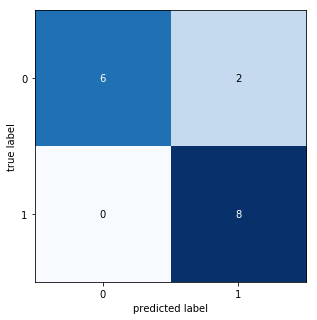


METRICAS:
Exactitud del ensemble (acc):  0.875
Sensibilidad (sens):  0.571
Especificidad (spec):  1.0
Precision (prec):  0.8
Recuperacion (recall):  1.0
F1:  0.889


In [54]:
# Metricas manuales para 2 clases (diagnostico), segun pag 74 memoria

# Reindexo para eliminar errores de comparacion
columnas = ['y_val2', 'y_val3', 'svm2', 'svm3', 'convsep2', 'convsep3', 'voting2', 'voting3']
resultados_val_id = resultados_val.reindex(columns=columnas)
resultados_val_id = resultados_val_id[columnas].astype(int)

resultados_val_id.head(20)

# Extraigo metricas segun pag 74 de la memoria

# Total predicciones por tipo
TotP_2 = resultados_val_id[resultados_val_id['voting2']==1]['voting2'].count()
TotN_2 = resultados_val_id[resultados_val_id['voting2']==0]['voting2'].count()

print('Total positivos TotP: ', TotP_2)
print('Total negativos TotN:', TotN_2)


# Solo verdaderas prediciones

#resultados_pos = resultados_val_id[resultados_val_id['y_val2']==1].reindex(columns=columnas)
#resultados_pos = resultados_pos[columnas].astype(int)

resultados_pos = resultados_val_id[resultados_val_id['y_val2']==1]
TP_2 = resultados_pos[resultados_pos['y_val2']==resultados_pos['voting2']]['y_val2'].count()
print('\nVerdaderos Positivos TP: ', TP_2)

resultados_neg = resultados_val_id[resultados_val_id['y_val2']==0]
TN_2 = resultados_neg[resultados_neg['y_val2']==resultados_neg['voting2']]['y_val2'].count()
print('Verdaderos Negativos TN: ', TN_2)

# Cuento falsos positivos y falsos negativos
FP_2 = TotP_2 - TP_2
FN_2 = TotN_2 - TN_2
print('\nFalsos Positivos FP: ', FP_2)
print('Falsos Negativos FN: ', FN_2)


# Cuento los aciertos y los fallos
TA_2 = resultados_val_id[resultados_val_id['y_val2']==resultados_val_id['voting2']]['y_val2'].count()
print('\nTotal aciertos TA: ', TA_2)

TF_2 = abs(TA_2 - resultados_val_id['y_val2'].count())
print('Total Fallos TF: ', TF_2)



# Dibujo la matriz de confusion para el ensemble (creando un numpy array)
CM = np.array([[TN_2, FP_2],[FN_2, TP_2]])

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()



# METRICAS DEL ENSEMBLE
print('\nMETRICAS:')
# Exactitud
print('Exactitud del ensemble (acc): ', round((TP_2+TN_2)/(TotP_2+TotN_2),3))
# Sensibilidad
print('Sensibilidad (sens): ', round(TP_2 / (TP_2+TN_2),3))
# Especificidad
print('Especificidad (spec): ', round(FP_2 / (FN_2+FP_2) ,3))
# Precision
print('Precision (prec): ', round(TP_2/(FP_2+TP_2) ,3))
# Recuperacion
print('Recuperacion (recall): ', round(TP_2/(FN_2+TP_2) ,3))
# F1
print('F1: ', round(2*(TP_2/(FN_2+TP_2))*(TP_2/(FP_2+TP_2))/((TP_2/(FN_2+TP_2))+(TP_2/(FP_2+TP_2))) ,3))


Total sanos TotNONE:  6
Total bacteria TotBAC: 10
Total virus TotVIR: 0

Verdaderos sanos TNONE:  6
Verdaderos bacteria TBAC:  8
Verdaderos virus TVIR:  0

Falsos sanos bacteria F0BAC:  2
Falsos sanos virus F0VIR:  0

Falsos bacteria sanos F1NONE:  0
Falsos bacteria virus F1VIR:  0

Falsos virus sanos F2NONE:  0
Falsos virus bacteria F2BAC:  0

Total aciertos TA:  14
Total Fallos TF:  2


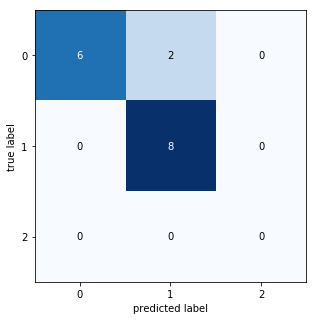


METRICAS:
Exactitud general del ensemble (acc):  0.875

Sensibilidad (sens): 
   sanos:  0.429
   bacterias:  0.571
   virus:  0.0

Especificidad (spec) 
   sanos:  0.0
   bacterias:  1.0
   virus:  0.0

Precision (prec): 
   sanos:  0.75
   bacterias:  1.0
   virus:  nan

Recuperacion (recall): 
   sanos 1.0
   bacterias:  0.8
   virus: nan

F1:    sanos:  0.857
   bacterias:  0.889
   virus:  nan


D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in long_scalars
D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in long_scalars
D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in long_scalars


In [61]:
# Metricas manuales para 3 clases (diagnostico), segun pag 74 memoria

# Extraigo metricas segun pag 74 de la memoria

# Total predicciones por tipo
TotNONE_3 = resultados_val_id[resultados_val_id['voting3']==0]['voting3'].count()
TotBAC_3 = resultados_val_id[resultados_val_id['voting3']==1]['voting3'].count()
TotVIR_3 = resultados_val_id[resultados_val_id['voting3']==2]['voting3'].count()

print('Total sanos TotNONE: ', TotNONE_3)
print('Total bacteria TotBAC:', TotBAC_3)
print('Total virus TotVIR:', TotVIR_3)


# Solo verdaderas prediciones
resultados_none = resultados_val_id[resultados_val_id['y_val3']==0]
TNONE_3 = resultados_none[resultados_none['y_val3']==resultados_none['voting3']]['y_val3'].count()
print('\nVerdaderos sanos TNONE: ', TNONE_3)

resultados_bac = resultados_val_id[resultados_val_id['y_val3']==1]
TBAC_3 = resultados_bac[resultados_bac['y_val3']==resultados_bac['voting3']]['y_val3'].count()
print('Verdaderos bacteria TBAC: ', TBAC_3)

resultados_vir = resultados_val_id[resultados_val_id['y_val3']==2]
TVIR_3 = resultados_vir[resultados_vir['y_val3']==resultados_vir['voting3']]['y_val3'].count()
print('Verdaderos virus TVIR: ', TVIR_3)


# Cuento falsos positivos y falsos negativos
F0BAC_3 = resultados_none[resultados_none['voting3']==1]['voting3'].count()
print('\nFalsos sanos bacteria F0BAC: ', F0BAC_3)
F0VIR_3 = resultados_none[resultados_none['voting3']==2]['voting3'].count()
print('Falsos sanos virus F0VIR: ', F0VIR_3)

F1NONE_3 = resultados_bac[resultados_bac['voting3']==0]['voting3'].count()
print('\nFalsos bacteria sanos F1NONE: ', F1NONE_3)
F1VIR_3 = resultados_bac[resultados_bac['voting3']==2]['voting3'].count()
print('Falsos bacteria virus F1VIR: ', F1VIR_3)

F2NONE_3 = resultados_vir[resultados_vir['voting3']==0]['voting3'].count()
print('\nFalsos virus sanos F2NONE: ', F2NONE_3)
F2BAC_3 = resultados_vir[resultados_vir['voting3']==1]['voting3'].count()
print('Falsos virus bacteria F2BAC: ', F2BAC_3)

# Cuento los aciertos y los fallos
TA_3 = resultados_val_id[resultados_val_id['y_val3']==resultados_val_id['voting3']]['y_val3'].count()
print('\nTotal aciertos TA: ', TA_3)

TF_3 = abs(TA_3 - resultados_val_id['y_val3'].count())
print('Total Fallos TF: ', TF_3)



# Dibujo la matriz de confusion para el ensemble (creando un numpy array)
CM = np.array([[TNONE_3, F0BAC_3, F0VIR_3],[F1NONE_3, TBAC_3, F1VIR_3], [F2NONE_3, F2BAC_3, TVIR_3]])

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()



# METRICAS DEL ENSEMBLE
print('\nMETRICAS:')

# Exactitud (verdaderos positivos de la clase / total positivos)
print('Exactitud general del ensemble (acc): ', round(np.trace(CM)/np.sum(CM),3))

# Sensibilidad (verdaderos positivos de la clase / total verdaderos)
print('\nSensibilidad (sens): \n   sanos: ', round(TNONE_3/np.trace(CM),3))
print('   bacterias: ', round(TBAC_3/np.trace(CM),3))
print('   virus: ', round(TVIR_3/np.trace(CM),3))

# Especificidad (falsos positivos de la clase / total falsos)
print('\nEspecificidad (spec) \n   sanos: ', round( (CM[1,0]+CM[2,0])/TF_3, 3))
print('   bacterias: ', round( (CM[0,1]+CM[2,1])/TF_3, 3))
print('   virus: ', round( (CM[0,2]+CM[1,2])/TF_3, 3))

# Precision (verdaderos positivos de la clase / total positivos verdaderos o falsos de la clase: columna)
print('\nPrecision (prec): \n   sanos: ', round(TNONE_3/CM[0,:].sum() ,3))
print('   bacterias: ', round(TBAC_3/CM[1,:].sum() ,3))
print('   virus: ', round(TVIR_3/CM[2,:].sum() ,3))

# Recuperacion (total verdaderos positivos de la clase / total positivos de la clase: fila)
print('\nRecuperacion (recall): \n   sanos', round(TNONE_3/CM[:,0].sum() ,3))
print('   bacterias: ', round(TBAC_3/CM[:,1].sum() ,3))
print('   virus:', round(TVIR_3/CM[:,2].sum() ,3))


# F1 (2 x precision x recall / (precision + recall))
print('\nF1:    sanos: ', round(2*(TNONE_3/CM[0,:].sum())*(TNONE_3/CM[:,0].sum()) / ((TNONE_3/CM[0,:].sum()) + (TNONE_3/CM[:,0].sum())) ,3))
print('   bacterias: ', round(2*(TBAC_3/CM[1,:].sum())*(TBAC_3/CM[:,1].sum()) / ((TBAC_3/CM[1,:].sum()) + (TBAC_3/CM[:,1].sum())) ,3))
print('   virus: ', round(2*(TVIR_3/CM[2,:].sum())*(TVIR_3/CM[:,2].sum()) / ((TVIR_3/CM[2,:].sum()) + (TVIR_3/CM[:,2].sum())) ,3))
